In [ ]:
# 04_evaluation.ipynb
# =====================================================
# Notebook: Évaluation du modèle ConvNeXt
# =====================================================

In [24]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.metrics import accuracy_score, precision_score,classification_report, cohen_kappa_score, roc_auc_score,recall_score, f1_score, confusion_matrix



In [26]:
# Redéfinir le chemin des données
dataset_path = r"C:\Users\user\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1"
test_dir = os.path.join(dataset_path, "Testing")
IMG_SIZE = 224

# Transformations pour le test (comme preprocessing)
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Créer le dataset test
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
BATCH_SIZE = 32
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [21]:
class_names = test_dataset.classes
num_classes = len(class_names)
print("Classes :", class_names)

Classes : ['glioma', 'meningioma', 'notumor', 'pituitary']


In [27]:
# --- Définir l'appareil ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

Device utilisé : cuda


In [28]:
# --- Créer le dossier results si n'existe pas ---
results_dir = "results/evaluation"
os.makedirs(results_dir, exist_ok=True)

In [29]:
# Recréer le modèle identique à l'entraînement
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.LayerNorm(768, eps=1e-06, elementwise_affine=True),
    nn.Dropout(p=0.3),
    nn.Linear(768, num_classes)
)
model.load_state_dict(torch.load("results/training/best_convnext_model.pth"))
model = model.to(device)
model.eval()


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [30]:
# -------------------------------
# 3. Prédictions et Labels
# -------------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -------------------------------
# 4. Métriques globales
# -------------------------------
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

metrics_df = pd.DataFrame([{
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1
}])

metrics_df.to_csv(os.path.join(results_dir, "evaluation_metrics.csv"), index=False)
print(metrics_df)

   Accuracy  Precision    Recall  F1-score
0  0.990847   0.990894  0.990847  0.990839


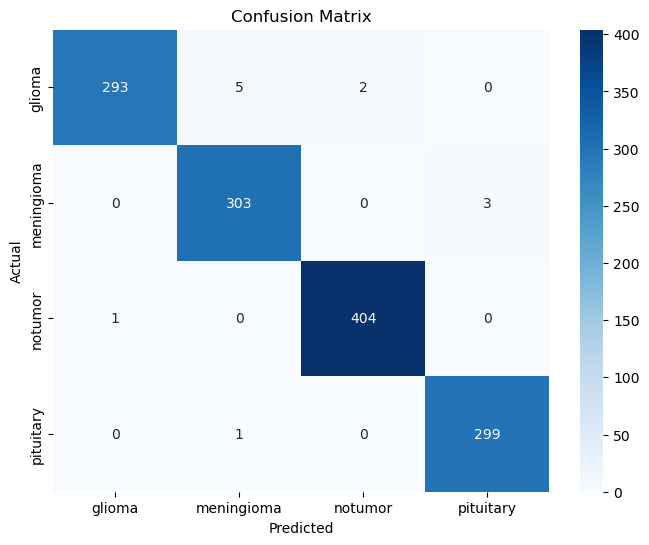

In [31]:
# -------------------------------
# 5. Matrice de confusion
# -------------------------------
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(results_dir, "confusion_matrix.png"))
plt.show()

In [35]:
cm

array([[293,   5,   2,   0],
       [  0, 303,   0,   3],
       [  1,   0, 404,   0],
       [  0,   1,   0, 299]], dtype=int64)

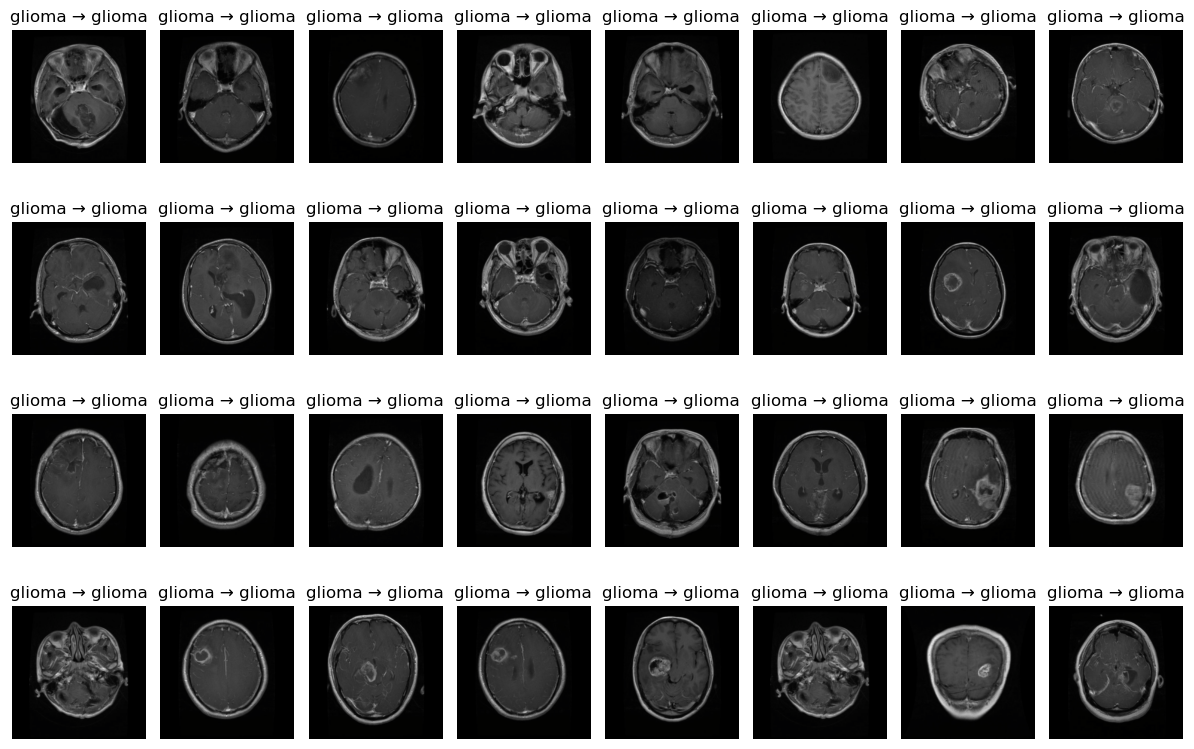

In [32]:
# -------------------------------
# 6. Affichage d’un batch
# -------------------------------
def imshow_batch(images, labels, preds):
    images = images.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)

    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(4, 8, i+1)
        plt.imshow(images[i])
        plt.title(f"{class_names[labels[i]]} → {class_names[preds[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

images, labels = next(iter(test_loader))
with torch.no_grad():
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)

imshow_batch(images, labels.numpy(), preds.cpu().numpy())


In [33]:
# -------------------------------
# 7. ROC-AUC par classe
# -------------------------------
y_true_bin = label_binarize(all_labels, classes=range(num_classes))

y_pred_scores = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(device))
        y_pred_scores.append(torch.softmax(outputs, dim=1).cpu().numpy())

y_pred_scores = np.vstack(y_pred_scores)

roc_auc_per_class = {
    class_names[i]: roc_auc_score(y_true_bin[:, i], y_pred_scores[:, i])
    for i in range(num_classes)
}

roc_auc_df = pd.DataFrame(list(roc_auc_per_class.items()), columns=["Classe", "ROC-AUC"])
roc_auc_df.to_csv(os.path.join(results_dir, "roc_auc_per_class.csv"), index=False)
print(roc_auc_df)

       Classe   ROC-AUC
0      glioma  0.999766
1  meningioma  0.999314
2     notumor  0.999967
3   pituitary  0.999383


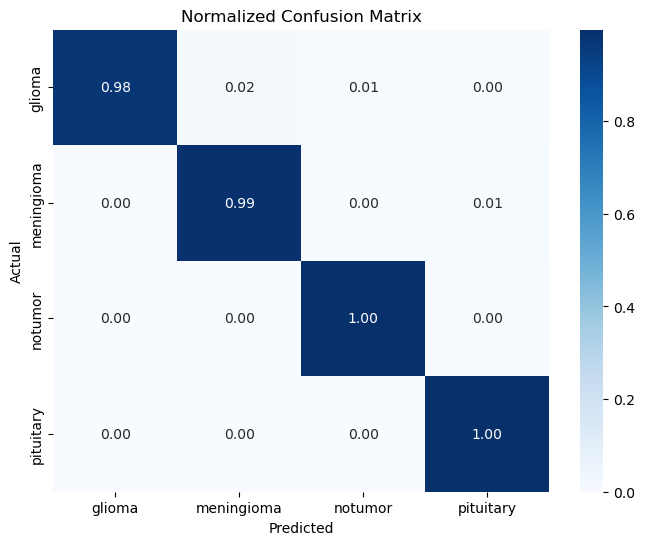

In [34]:
# -------------------------------
# 8. Matrice de confusion normalisée
# -------------------------------
cm_norm = confusion_matrix(all_labels, all_preds, normalize='true')

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(results_dir, "confusion_matrix_normalized.png"))
plt.show()